# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [17]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact 
%matplotlib inline
import panel.widgets
# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [2]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_token)
print(type(mapbox_token))

<class 'str'>


# Import Data

In [3]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [36]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    # YOUR CODE HERE!
    year_house_units = sfo_data.drop(columns =['sale_price_sqr_foot', 'gross_rent', 'neighborhood'])
    housing_units = year_house_units.groupby(['year']).mean()
    housing_min = housing_units['housing_units'].min()
    housing_max = housing_units['housing_units'].max()
    housing_units_bar_plot = housing_units.plot.bar(ylim=(housing_min-3000,housing_max+3000),title = "Housing Units in San Francisco from 2010 to 2016")
    return pn.panel(housing_units_bar_plot)


In [37]:
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    # YOUR CODE HERE!
    sale_price_gross_rent = sfo_data.drop(columns = ['neighborhood','housing_units'])
    average_sale_rent = sale_price_gross_rent.groupby('year').mean()
    plot_title = "Average Gross Rent in San Francisco"
    avg_gross_rent_plot = average_sale_rent['gross_rent'].plot.line(title = plot_title)
    return pn.panel(avg_gross_rent_plot)

In [38]:
def average_sales_price():
    """Average Sales Price Per Year."""
    # YOUR CODE HERE!
    sale_price_gross_rent = sfo_data.drop(columns = ['neighborhood','housing_units'])
    average_sale_rent = sale_price_gross_rent.groupby('year').mean()
    avg_sale_price_plot = average_sale_rent['sale_price_sqr_foot'].plot.line(title = "Average Sale Price per Square Foot in San Francisco")
    return pn.panel(avg_sale_price_plot)

In [7]:
def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    # YOUR CODE HERE!
    year_neighborhood_avg = sfo_data.groupby([sfo_data.index, 'neighborhood']).mean()
    yearly_sales = year_neighborhood_avg['sale_price_sqr_foot']
    yearly_sales_df = pd.DataFrame(yearly_sales).reset_index()
    def sales_plot(SF_neighborhood):
    
        neigh_plot = yearly_sales_df.loc[yearly_sales_df['neighborhood']==SF_neighborhood,:].hvplot.line(
        x = 'year',
        y = 'sale_price_sqr_foot'
    )
        return neigh_plot
    user_choice= yearly_sales_df['neighborhood']
    sales_plot = interact(sales_plot, SF_neighborhood = user_choice )
    return sales_plot

In [40]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    # YOUR CODE HERE!
    mean_sale_price = sfo_data.groupby('neighborhood').mean()
    most_expensive_neigh = mean_sale_price.sort_values(by = 'sale_price_sqr_foot', ascending = False).reset_index()
    ten_most_expensive = most_expensive_neigh.loc[0:9]
    top_most_plot = ten_most_expensive.plot.bar(x = 'neighborhood', y= 'sale_price_sqr_foot',title = "SF's Top 10 Expensive Neighborhoods")    
    
    return pn.panel(top_most_plot)
    

In [9]:
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    # YOUR CODE HERE!
    mean_sale_price = sfo_data.groupby('neighborhood').mean()
    most_expensive_neigh = mean_sale_price.sort_values(by = 'sale_price_sqr_foot', ascending = False).reset_index()
    ten_most_expensive = most_expensive_neigh.loc[0:9]
    parallel_coord = px.parallel_coordinates(ten_most_expensive, color = 'sale_price_sqr_foot')
    return parallel_coord

In [10]:
def parallel_categories():
    """Parallel Categories Plot."""
    
    # YOUR CODE HERE!
    mean_sale_price = sfo_data.groupby('neighborhood').mean()
    most_expensive_neigh = mean_sale_price.sort_values(by = 'sale_price_sqr_foot', ascending = False).reset_index()
    ten_most_expensive = most_expensive_neigh.loc[0:9]
    parallel_cat_plot = px.parallel_categories(
        ten_most_expensive, 
        color = 'sale_price_sqr_foot',
        dimensions= ['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'],
        color_continuous_scale=px.colors.sequential.Inferno,
)
    return parallel_cat_plot

In [11]:
def neighborhood_map():
    """Neighborhood Map"""
    
    # YOUR CODE HERE!
    mean_values = sfo_data.groupby('neighborhood').mean().reset_index()
    combined_df = pd.concat([df_neighborhood_locations, mean_values], axis = 'columns', join = 'inner')
    neigh_map_scatter = px.scatter_mapbox(combined_df, lat='Lat', lon='Lon', color= 'neighborhood')
    return neigh_map_scatter

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

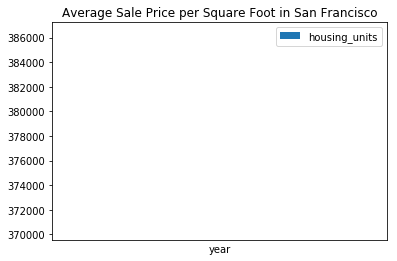

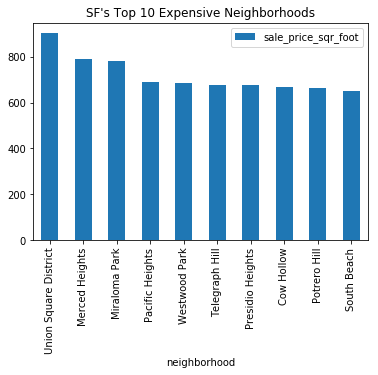

In [41]:
# YOUR CODE HERE!
sf_map = pn.Column("#San Francisco Real Estate from 2010-2016", neighborhood_map())

yearly_averages = pn.Column(
    housing_units_per_year(), 
    average_gross_rent(), 
    average_sales_price()
)

neighborhood_prices = pn.Column(
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods()
)

parallel_plots = pn.Column(
    parallel_coordinates(), 
    parallel_categories()
)


panel = pn.Tabs(
    ("San Francisco Map", sf_map),
    ("Yearly Averages", yearly_averages),      
    ("Neighborhood Prices", neighborhood_prices),
    ("Parallel Plots", parallel_plots))

## Serve the Panel Dashboard

In [42]:
panel.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Column
        [0] Str(AxesSubplot)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
    [2] Column
        [0] Column
            [0] Column
                [0] Select(name='SF_neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive01803')
        [1] Str(AxesSubplot)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)